# Filter 2: Pharmacophore Screening for α2A-Selective GABA-A Modulators

## Final Project: In Silico Identification of Novel Positive Allosteric Modulators (PAMs) for GABA-A Receptors in Anxiety Treatment

**Student:** Pablo Rodríguez López.    
**Course**: Computational Structural Biology for Lead Discovery.   
**University**: Polytechnic University of Madrid.    
**Date:** January 2026.   
**Objective:** Create a ligand-based 3D pharmacophore model from known α2A-selective GABA-A modulators and use it to filter LBVS hits (380 compounds) from Filter 1.

## Project Context
- **Target**: α2A subunit-selective GABA-A receptors
- **Therapeutic Goal**: Anxiolytic activity without sedation
- **Drug-like Criteria**: Lipinski-compliant
- **Selectivity Focus**: α2 > α1 (log2 ratio > 1)

## Methodology
Adapted from the course's COX-2 pharmacophore notebook:
1. Import libraryes. Load α2A-selective training set (97 compounds) and the screening library (380 compounds) from filter 1.
2. Convert SMILES to Mol objects: addying hydrogenes, generating 3D structure and minimizing it. Align the molecules
3. Extract pharmacophoric features (Donor, Acceptor, Aromatic, Hydrophobic, etc.)
4. Build a pharmacophore model from common features
5. Screen LBVS hits and rank by pharmacophore fit
6. Validate with control compounds
7. Select top 10 hits

---

## 1. Import libraries and data

### 1.1 Install and Import Required Libraries

In [ ]:
# Install RDKit if not already installed
!pip install rdkit -q
!pip install py3Dmol

In [ ]:
# Import essential libraries
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolAlign, Draw, ChemicalFeatures, RDConfig
import py3Dmol
import os
import collections
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import random
# set seed
random.seed(42)

# from rdkit.Chem.Draw import IPythonConsole
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully")
print(f"RDKit version: {Chem.rdBase.rdkitVersion}")

 All libraries imported successfully
RDKit version: 2025.09.3


## 1.2. Load Training Set and LBVS Hits

In [ ]:
# Load α2A-selective training set (97 compounds)
df_training = pd.read_csv('Training_set_alpha2_selective.csv')

print(f" Training set loaded: {len(df_training)} α2A-selective compounds")
print(f"  Columns: {list(df_training.columns)}")
print(f"\nFirst 3 compounds:")
df_training.rename(columns={'canonical_smiles': 'SMILES'}, inplace=True)
display(df_training[['ChEMBL_ID', 'SMILES', 'pKi_alpha2','log2_ratio']].head(5))

 Training set loaded: 22 α2A-selective compounds
  Columns: ['canonical_smiles', 'Ki_alpha1', 'Ki_alpha2', 'ChEMBL_ID', 'log2_ratio', 'refined_label', 'pKi_alpha1', 'pKi_alpha2']

First 3 compounds:


,ChEMBL_ID,SMILES,pKi_alpha2,log2_ratio
0,CHEMBL505768,C#Cc1ccc2c(c1)C(c1ccccc1)=NCc1c(C(=O)OCCCOC(=O...,8.130768,4.995118
1,CHEMBL50581,c1ccc(COc2nn3c(-c4ccccc4)nnc3c3ccccc23)cc1,7.795880,4.129283
2,CHEMBL123882,Cc1cccc(COc2nn3c(-c4nc(C(C)C)no4)nnc3c3c2C2CCC...,7.164944,3.869860
3,CHEMBL52672,c1ccc(-c2nnc3c4ccccc4c(OCc4ccncc4)nn23)cc1,8.769551,3.819428
4,CHEMBL291335,COC(=O)c1cc(-c2ccc(OC)cc2)c(-c2cccnc2)n(C)c1=O,7.119186,3.161463


In [ ]:
# Load LBVS hits to screen (380 compounds from Filter 1)
df_lbvs = pd.read_csv('LBVS_hits_filtered_0.3.csv')

print(f" LBVS hits loaded: {len(df_lbvs)} compounds")
print(f"  Columns: {list(df_lbvs.columns)}")
print(f"\nFirst 3 hits:")
display(df_lbvs[['ChEMBL_ID', 'SMILES']].head(5))

 LBVS hits loaded: 160 compounds
  Columns: ['ChEMBL_ID', 'SMILES', 'MW', 'LogP', 'HBA', 'HBD', 'RotBonds', 'TPSA', 'AromaticRings', 'Similarity_Max']

First 3 hits:


,ChEMBL_ID,SMILES
0,CHEMBL276508,CSc1sc(-c2ccncc2)c2c1C(=O)CC(C)(C)C2
1,CHEMBL17698,CSc1sc(-c2ccccn2)c2c1C(=O)CC(C)(C)C2
2,CHEMBL286594,C#Cc1ccc2c(c1)C(=O)N(C)Cc1c(C(=O)OCC)ncn1-2
3,CHEMBL277504,CSc1sc(-c2nccs2)c2c1C(=O)CC(C)(C)C2
4,CHEMBL17354,CSc1sc(-c2cc[nH]n2)c2c1C(=O)CC(C)(C)C2


In [ ]:
# Compound with the highest "Similarity_Max" in our screening set:
df_lbvs[df_lbvs['Similarity_Max'] == df_lbvs['Similarity_Max'].max()]

,ChEMBL_ID,SMILES,MW,LogP,HBA,HBD,RotBonds,TPSA,AromaticRings,Similarity_Max
0,CHEMBL276508,CSc1sc(-c2ccncc2)c2c1C(=O)CC(C)(C)C2,303.452,4.6871,4,0,2,29.96,2,0.76087


---

## 2. Prepare Training Set: Convert SMILES to 3D Molecules

**Methodology**: Following the approach seen in class:
- Convert SMILES to RDKit molecules
- Add hydrogens for proper 3D geometry
- Generate 3D coordinates
- Minimize energy using MMFF force field
- Store 3D-optimized molecules


Additionally:
- Align 3D structures
- Convert to MolBlocks for visualization

In [ ]:
def prepare_molecules_3d(smiles_list, names_list, conformers=False, num_conformers=3):
    """
    Convert SMILES to 3D molecules with proper geometry optimization.

    Args:
        smiles_list: List of SMILES strings
        names_list: List of molecule names/IDs
        conformers: Whether to generate multilple conformers or not
        num_conformers: Number of conformers to generate per molecule

    Returns:
        molecules_dict: {name: optimized_mol_with_3D}
        failed_smiles: List of failed SMILES conversions
    """
    molecules_dict = {}
    failed_smiles = []

    for i, (smi, name) in enumerate(zip(smiles_list, names_list)):
        try:
            # Convert SMILES to molecule
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                failed_smiles.append((name, smi, "Invalid SMILES"))
                continue

            # Add hydrogens for proper 3D geometry
            mol = Chem.AddHs(mol)

            # Generate 3D coordinates, with or without conformers:
            if conformers:
              conf_ids = AllChem.EmbedMultipleConfs(mol, numConfs=num_conformers, params=AllChem.ETKDG())
              if len(conf_ids) == 0:
                  print(f"WARNING: Could not generate 3D conformer for {name}")
                  failed_smiles.append((name, smi, "Could not generate 3D conformer"))
                  continue
              # Optimize all conformers
              for conf_id in conf_ids:
                  AllChem.UFFOptimizeMolecule(mol, confId=conf_id)
              mol.SetProp("_Name", name)
            else:
              # Generate the 3D coordinates
              AllChem.EmbedMolecule(mol)
              # Optimize all conformers with MMFF force field
              AllChem.MMFFOptimizeMolecule(mol)

            # Store molecule
            molecules_dict[name] = mol

            # Print a progress message
            if (i + 1) % 20 == 0:
                print(f"  Processed {i + 1}/{len(names_list)} molecules...")

        except Exception as e:
            failed_smiles.append((name, smi, str(e)))

    return molecules_dict, failed_smiles

print(" Molecule preparation function defined")

 Molecule preparation function defined


In [ ]:
# Prepare training set molecules
print("Preparing training set molecules (3D optimization)...")

training_mols, failed_training = prepare_molecules_3d(
    df_training['SMILES'].values,
    df_training['ChEMBL_ID'].values,
)

print(f"\n Training set prepared:")
print(f"  Successfully converted: {len(training_mols)} molecules")
print(f"  Failed conversions: {len(failed_training)} molecules")

if failed_training:
    if len(failed_training) > 3:
        print(f"\nFirst 3 failed molecules:")
        for name, smi, reason in failed_training[:3]:
            print(f"  {name}: {reason}")
    else:
        print(f"\nFailed molecules:")
        for name, smi, reason in failed_training:
            print(f"  {name}: {reason}")

Preparing training set molecules (3D optimization)...
  Processed 20/22 molecules...

 Training set prepared:
  Successfully converted: 22 molecules
  Failed conversions: 0 molecules


### Visualization of the whole training set

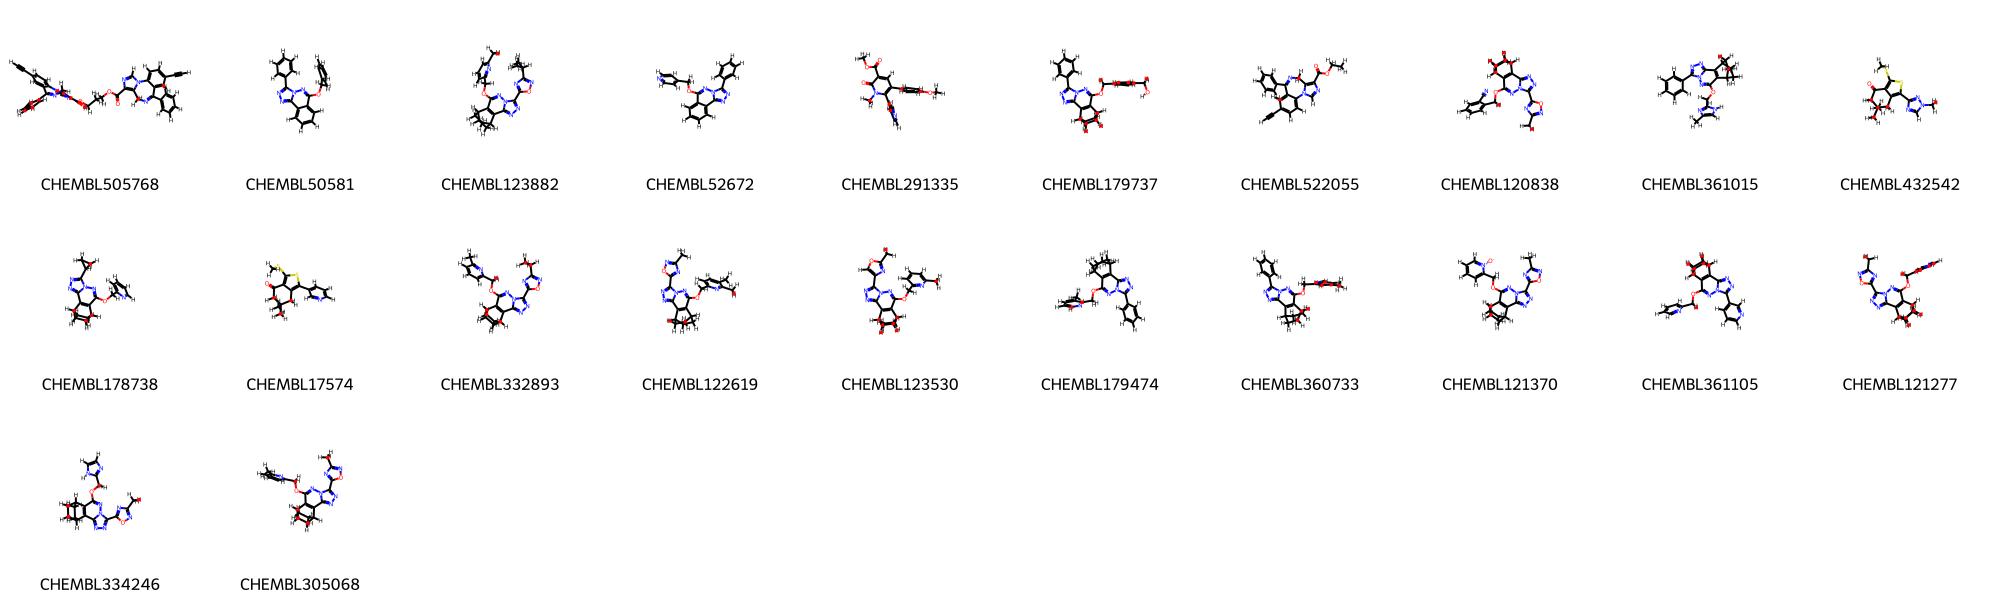

In [ ]:
Draw.MolsToGridImage(list(training_mols.values()),molsPerRow=10,legends=list(training_mols.keys()))

### Align molecules to the first ligand

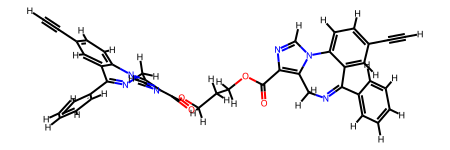

In [ ]:
list(training_mols.values())[0]

In [ ]:
list(training_mols.keys())[0]

'CHEMBL505768'

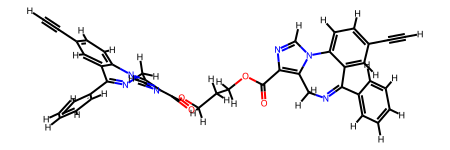

In [ ]:
training_mols[list(training_mols.keys())[0]]

In [ ]:
ref_mol = training_mols[list(training_mols.keys())[0]]

# O3A
for name, mol in training_mols.items():
    if name != list(training_mols.keys())[0]:
        o3a = rdMolAlign.GetO3A(mol, ref_mol)
        rmsd = o3a.Align()

print("Training set molecules successfully aligned to the first ligand")
print(f"  RMSD: {rmsd:.3f}")

Training set molecules successfully aligned to the first ligand
  RMSD: 0.527


Visualization of the first 10 molecules aligned

In [ ]:
# Convert all aligned molecules to MolBlocks for visualization
mol_blocks = []
for name, mol in training_mols.items():
    mb = Chem.MolToMolBlock(mol)
    mol_blocks.append((name, mb))

# Create a 3D viewer
viewer = py3Dmol.view(width=500, height=500)

# Add each molecule with a different color style
colors = ["blue", "green", "orange", "purple", "red", "cyan", "magenta", "yellow", "black", "white"]
first10_mol_blocks = mol_blocks[:10]
for i, (name, mb) in enumerate(first10_mol_blocks):
    viewer.addModel(mb, "mol")
    # Use modulo operator to cycle through colors if there are more molecules than defined colors
    viewer.setStyle({"model": i}, {"stick": {"color": colors[i % len(colors)]}})

viewer.zoomTo()
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

---

## 4. Extract Pharmacophoric Features from Training Set

**Feature Types** (from RDKit's BaseFeatures.fdef):
- **Donor**: Hydrogen bond donors (NH, OH)
- **Acceptor**: Hydrogen bond acceptors (N, O)
- **Aromatic**: Aromatic ring centers (Arom6)
- **Hydrophobe**: Hydrophobic groups (ThreeWayAttach)
- **LumpedHydrophobe**: Extended hydrophobic regions (RH66)
- **NegIonizable**: Carboxylic acids, phosphates (AcidicGroup)

In [ ]:
# Load RDKit's feature definition file
fdefname = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefname)

print(f" Feature factory loaded from: {fdefname}")
print(f"  Available feature types: {len(factory.GetFeatureDefs())} types")

 Feature factory loaded from: /usr/local/lib/python3.12/dist-packages/rdkit/Data/BaseFeatures.fdef
  Available feature types: 27 types


In [ ]:
# Extract features from all training molecules (using first conformer)
pharmacophore_data = {}

# Detect features for each molecule
pharmacophore_data = {}
for name, mol in training_mols.items():
    feats = factory.GetFeaturesForMol(mol)
    pharmacophore_data[name] = [(f.GetType(), f.GetFamily(), f.GetPos()) for f in feats]

# Print message of from how many molecules we could extract features
count=0
for name, features in pharmacophore_data.items():
    if features:
      count+=1
print(f"\n Extracted features from {count} molecules")


# Print detected features for the first 5 molecules
count=0
for name, features in pharmacophore_data.items():
    print(f"\n{name} Pharmacophore Features:")
    for ftype, ffamily,pos in features:
        print(f" - {ftype} ({ffamily}) ")
    count+=1
    if count==10:
      break


 Extracted features from 22 molecules

CHEMBL505768 Pharmacophore Features:
 - SingleAtomAcceptor (Acceptor) 
 - SingleAtomAcceptor (Acceptor) 
 - SingleAtomAcceptor (Acceptor) 
 - SingleAtomAcceptor (Acceptor) 
 - SingleAtomAcceptor (Acceptor) 
 - SingleAtomAcceptor (Acceptor) 
 - Imidazole (PosIonizable) 
 - Imidazole (PosIonizable) 
 - Arom5 (Aromatic) 
 - Arom5 (Aromatic) 
 - Arom6 (Aromatic) 
 - Arom6 (Aromatic) 
 - Arom6 (Aromatic) 
 - Arom6 (Aromatic) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydrophobe) 
 - ThreeWayAttach (Hydr

In [ ]:
# Display feature statistics
feature_families = collections.Counter()

for mol_name, features in pharmacophore_data.items():
    for feat in features:
        feature_families[feat[1]] += 1

print("Feature family frequencies in training set:")
for family, count in sorted(feature_families.items(), key=lambda x: x[1], reverse=True):
    print(f"  {family}: {count} occurrences")

Feature family frequencies in training set:
  Hydrophobe: 324 occurrences
  Acceptor: 102 occurrences
  Aromatic: 67 occurrences
  LumpedHydrophobe: 37 occurrences
  PosIonizable: 6 occurrences
  Donor: 6 occurrences


In [ ]:
rows = []
for name, features in pharmacophore_data.items():
    for ftype, ffamily, pos in features:
        rows.append({
            "Ligand": name,
            "Feature_Type": ftype,
            "Feature_Family": ffamily,
            "X": round(pos.x, 3),
            "Y": round(pos.y, 3),
            "Z": round(pos.z, 3)
        })

# Crear DataFrame
df_features = pd.DataFrame(rows)

# Crear resumen de recuento de familias de features por ligando
summary = df_features.groupby(["Ligand", "Feature_Family"]).size().unstack(fill_value=0)

# Mostrar solo la tabla resumen
print("Pharmacophore Feature Family Summary per Ligand (first 10 molecules):")
display(summary[:10])

Pharmacophore Feature Family Summary per Ligand (first 10 molecules):


Feature_Family,Acceptor,Aromatic,Donor,Hydrophobe,LumpedHydrophobe,PosIonizable
Ligand,,,,,,
CHEMBL120838,5,3,0,15,2,0
CHEMBL121277,6,3,0,12,1,0
CHEMBL121370,5,3,0,12,1,1
CHEMBL122619,6,3,0,14,1,0
CHEMBL123530,5,3,0,13,1,0
CHEMBL123882,6,3,0,15,2,0
CHEMBL17574,2,2,0,13,1,0
CHEMBL178738,4,2,0,14,2,0
CHEMBL179474,4,3,0,18,2,0


---

## 5. Build Ensemble Pharmacophore from Common Features

**Criteria for consensus features**:
- **MIN_MATCHES**: Must appear in at least this number of training compounds
- **DIST_THRESHOLD**: 1.5 Å spatial tolerance between aligned features


After that, this model is screened through Filter 2 survivors. Then, each of these will have some subset of the Pharmacophore features. So we will filter leads with more than X% of the model's features. So in this filter we have two main parameters: MIN_MATCHES and min_features_fraction. Should we choose a conservative MIN_MATCHES value and a relaxed threshold percentage, or viceversa?

I decided to be conservative with MIN_MATCHES (MIN_MATCHES = 10 (out of 22)) and more permissive with the final threshold (20%). Choosing MIN_MATCHES = 10/22 ensures that only features present in nearly half of the highly α2-selective ligands are retained, so the pharmacophore encodes robust, consensus determinants rather than chemotype-specific noise. This makes the model more stable and less prone to overfitting in the small-N regime. Combining that with a 20 % coverage threshold during screening keeps Filter 2 deliberately sensitive, allowing compounds that reproduce at least part of this consensus pattern to pass, even if they do not perfectly overlay all features. In practice, this pairing prioritizes selectivity-enriched, well-supported features at model-building time, while maintaining enough flexibility at screening time to preserve chemotype diversity and avoid discarding potentially novel α2-selective scaffolds too early.

In [ ]:
def build_consensus_pharmacophore(pharmacophore_data, min_matches=3, dist_threshold=1.5):
    """
    Build ensemble pharmacophore from common features across multiple ligands.

    Args:
        pharmacophore_data: Dict of {mol_name: [features]}
        min_matches: Minimum number of ligands sharing a feature
        dist_threshold: Distance threshold (Å) for feature matching

    Returns:
        df_pharmacophore: DataFrame with consensus features
    """
    common_features = []

    # Get unique feature families
    all_families = set()
    for features in pharmacophore_data.values():
        for feat in features:
            all_families.add(feat[1]) # Access family by index

    print(f"Processing {len(all_families)} feature families...\n")

    # For each feature family
    for fam in sorted(all_families):
        print(f"  {fam}...", end='', flush=True)

        # Get all instances of this family across all molecules
        fam_coords = {}  # {mol_name: [coord1, coord2, ...]}

        for mol_name, features in pharmacophore_data.items():
            coords = []
            for feat in features:
                if feat[1] == fam: # Access family by index
                    # Access coordinates from the Point3D object at index 2
                    coords.append(np.array([feat[2].x, feat[2].y, feat[2].z]))
            if coords:
                fam_coords[mol_name] = coords

        # If no molecules have this feature, skip
        if not fam_coords:
            print(" (No instances found)")
            continue

        # Choose reference molecule (first one in the dict that has coordinates for this family)
        ref_mol_name = list(fam_coords.keys())[0]
        ref_coords_list = fam_coords[ref_mol_name]

        # For each reference feature
        for ref_point in ref_coords_list:
            matches = 1  # Reference molecule itself counts as 1 match
            positions = [ref_point]

            # Compare to other molecules
            for other_mol, other_coords in fam_coords.items():
                if other_mol == ref_mol_name:
                    continue

                # Find closest feature in other molecule
                if len(other_coords) > 0:
                    dists = cdist([ref_point], other_coords)[0]
                    min_dist = dists.min()

                    # If within threshold, count as match
                    if min_dist <= dist_threshold:
                        matches += 1
                        positions.append(other_coords[dists.argmin()])

            # If enough molecules share this feature, add to pharmacophore
            if matches >= min_matches:
                avg_pos = np.mean(positions, axis=0)
                common_features.append({
                    'Feature_Family': fam,
                    'X': round(avg_pos[0], 3),
                    'Y': round(avg_pos[1], 3),
                    'Z': round(avg_pos[2], 3),
                    'SharedBy': matches
                })


    # Create DataFrame and remove duplicates
    df_common = pd.DataFrame(common_features).drop_duplicates()
    df_common = df_common.sort_values('SharedBy', ascending=False).reset_index(drop=True)

    return df_common

print(" Consensus pharmacophore function defined")

 Consensus pharmacophore function defined


In [ ]:
# Build consensus pharmacophore
print("Building consensus pharmacophore from training set...\n")

MIN_MATCHES = 10  # At least this number of α2A ligands must share the feature
DIST_THRESHOLD = 1.5  # 1.5 Å tolerance

df_pharmacophore = build_consensus_pharmacophore(
    pharmacophore_data,
    min_matches=MIN_MATCHES,
    dist_threshold=DIST_THRESHOLD
)

print(f"\n Consensus pharmacophore generated:")
print(f"  Total features: {len(df_pharmacophore)}")
print(f"  Minimum matches required: {MIN_MATCHES}")
print(f"  Distance threshold: {DIST_THRESHOLD} Å")

Building consensus pharmacophore from training set...

Processing 6 feature families...

  Acceptor...  Aromatic...  Donor...  Hydrophobe...  LumpedHydrophobe...  PosIonizable...
 Consensus pharmacophore generated:
  Total features: 10
  Minimum matches required: 10
  Distance threshold: 1.5 Å


In [ ]:
# Display pharmacophore features
print("\nConsensus Pharmacophore Features for α2A-Selective Modulators:")
print("="*70)
display(df_pharmacophore)

# Feature distribution
feature_dist = df_pharmacophore['Feature_Family'].value_counts()
print("\nFeature distribution in pharmacophore:")
for family, count in feature_dist.items():
    print(f"  {family}: {count} features")


Consensus Pharmacophore Features for α2A-Selective Modulators:


,Feature_Family,X,Y,Z,SharedBy
0,Hydrophobe,-8.978,1.364,0.586,19
1,Aromatic,-4.933,-0.359,2.478,19
2,Hydrophobe,-7.743,0.712,0.796,18
3,Acceptor,-4.198,-0.718,3.267,17
4,Hydrophobe,-8.074,1.373,3.035,17
5,Hydrophobe,-9.245,2.445,1.488,17
6,Hydrophobe,-8.731,2.406,2.755,17
7,LumpedHydrophobe,-8.757,1.445,1.899,16
8,Hydrophobe,-0.532,-1.590,-0.567,11
9,Acceptor,-2.726,-1.402,-0.038,10



Feature distribution in pharmacophore:
  Hydrophobe: 6 features
  Acceptor: 2 features
  Aromatic: 1 features
  LumpedHydrophobe: 1 features


In [ ]:
# Add aligned molecules to the viewer
viewer = py3Dmol.view(width=500, height=500)
for i, (name, mb) in enumerate(first10_mol_blocks):
    viewer.addModel(mb, "mol")
    viewer.setStyle({"model": i}, {"stick": {"color": "white"}})

# Add spheres representing common pharmacophore features
feature_colors = {
    "Hydrophobe": "yellow",
    "LumpedHydrophobe": "gold",
    "Aromatic": "magenta",
    "Donor": "cyan",
    "Acceptor": "red",
    "PosIonizable": "blue",
    "NegIonizable": "orange"
}

for _, row in df_pharmacophore.iterrows():
    # Choose color based on feature family, default is white
    fcolor = feature_colors.get(row["Feature_Family"], "white")

    # Add a semi-transparent sphere at the average position of the feature
    viewer.addSphere({
        "center": {"x": row["X"], "y": row["Y"], "z": row["Z"]},
        "radius": 0.7,   # sphere size
        "color": fcolor, # sphere color
        "alpha": 1     # transparency to see molecules underneath
    })

# Adjust view and display
viewer.zoomTo()  # center and zoom to include all models and features
viewer.show()    # render the interactive 3D viewer

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# Create mol2 file to use in pharmit
feature2atom = {
    "Hydrophobe": "H",
    "LumpedHydrophobe": "L",
    "Aromatic": "Ar",
    "Donor": "D",
    "Acceptor": "A",
    "PosIonizable": "P",
    "NegIonizable": "N"
}

mol2_file = "/content/pharmacophore_features.mol2"

with open(mol2_file, "w") as f:
    # Header
    f.write("@<TRIPOS>MOLECULE\n")
    f.write("pharmacophore\n")
    n_atoms = len(df_pharmacophore)
    n_bonds = 0
    f.write(f"{n_atoms} {n_bonds} 0 0 0\n")
    f.write("SMALL\nGASTEIGER\n\n")

    # Atoms
    f.write("@<TRIPOS>ATOM\n")
    for i, row in enumerate(df_pharmacophore.itertuples(), 1):
        atom_type = feature2atom.get(row.Feature_Family, "Du")  # Du = dummy
        f.write(f"{i:>7}  {row.X:>8.3f}  {row.Y:>8.3f}  {row.Z:>8.3f}  {atom_type:<4}  1  0.000\n")

    # Bonds (none)
    f.write("@<TRIPOS>BOND\n")

print(f"Pharmacophore exported to Mol2 file: {mol2_file}")


Pharmacophore exported to Mol2 file: /content/pharmacophore_features.mol2


---

## 6. Screen LBVS Hits Against Pharmacophore

**Scoring strategy**:
- For each LBVS compound:
  1. Generate 3D conformers
  2. Extract pharmacophoric features
  3. Calculate how many pharmacophore features are matched
  4. Assign score (0 to N, where N = total pharmacophore features)
- Rank by score (higher = better pharmacophore fit)

In [ ]:
# Prepare LBVS hits for screening
print("Preparing LBVS hits molecules (3D optimization)...")
conformer_param=True
NUM_CONFORMERS = 5
lbvs_mols, failed_lbvs = prepare_molecules_3d(
    df_lbvs['SMILES'].values,
    df_lbvs['ChEMBL_ID'].values,
    conformers=conformer_param,
    num_conformers=NUM_CONFORMERS
)

print(f"\n  LBVS hits prepared:")
if conformer_param:
  print(f"  Successfully converted: {len(lbvs_mols)} molecules, with up to {NUM_CONFORMERS} conformers each.")
else:
  print(f"  Successfully converted: {len(lbvs_mols)} molecules.")
print(f"  Failed conversions: {len(failed_lbvs)} molecules")

Preparing LBVS hits molecules (3D optimization)...
  Processed 20/160 molecules...
  Processed 40/160 molecules...
  Processed 60/160 molecules...
  Processed 80/160 molecules...
  Processed 100/160 molecules...
  Processed 120/160 molecules...
  Processed 140/160 molecules...
  Processed 160/160 molecules...

  LBVS hits prepared:
  Successfully converted: 160 molecules, with up to 5 conformers each.
  Failed conversions: 0 molecules


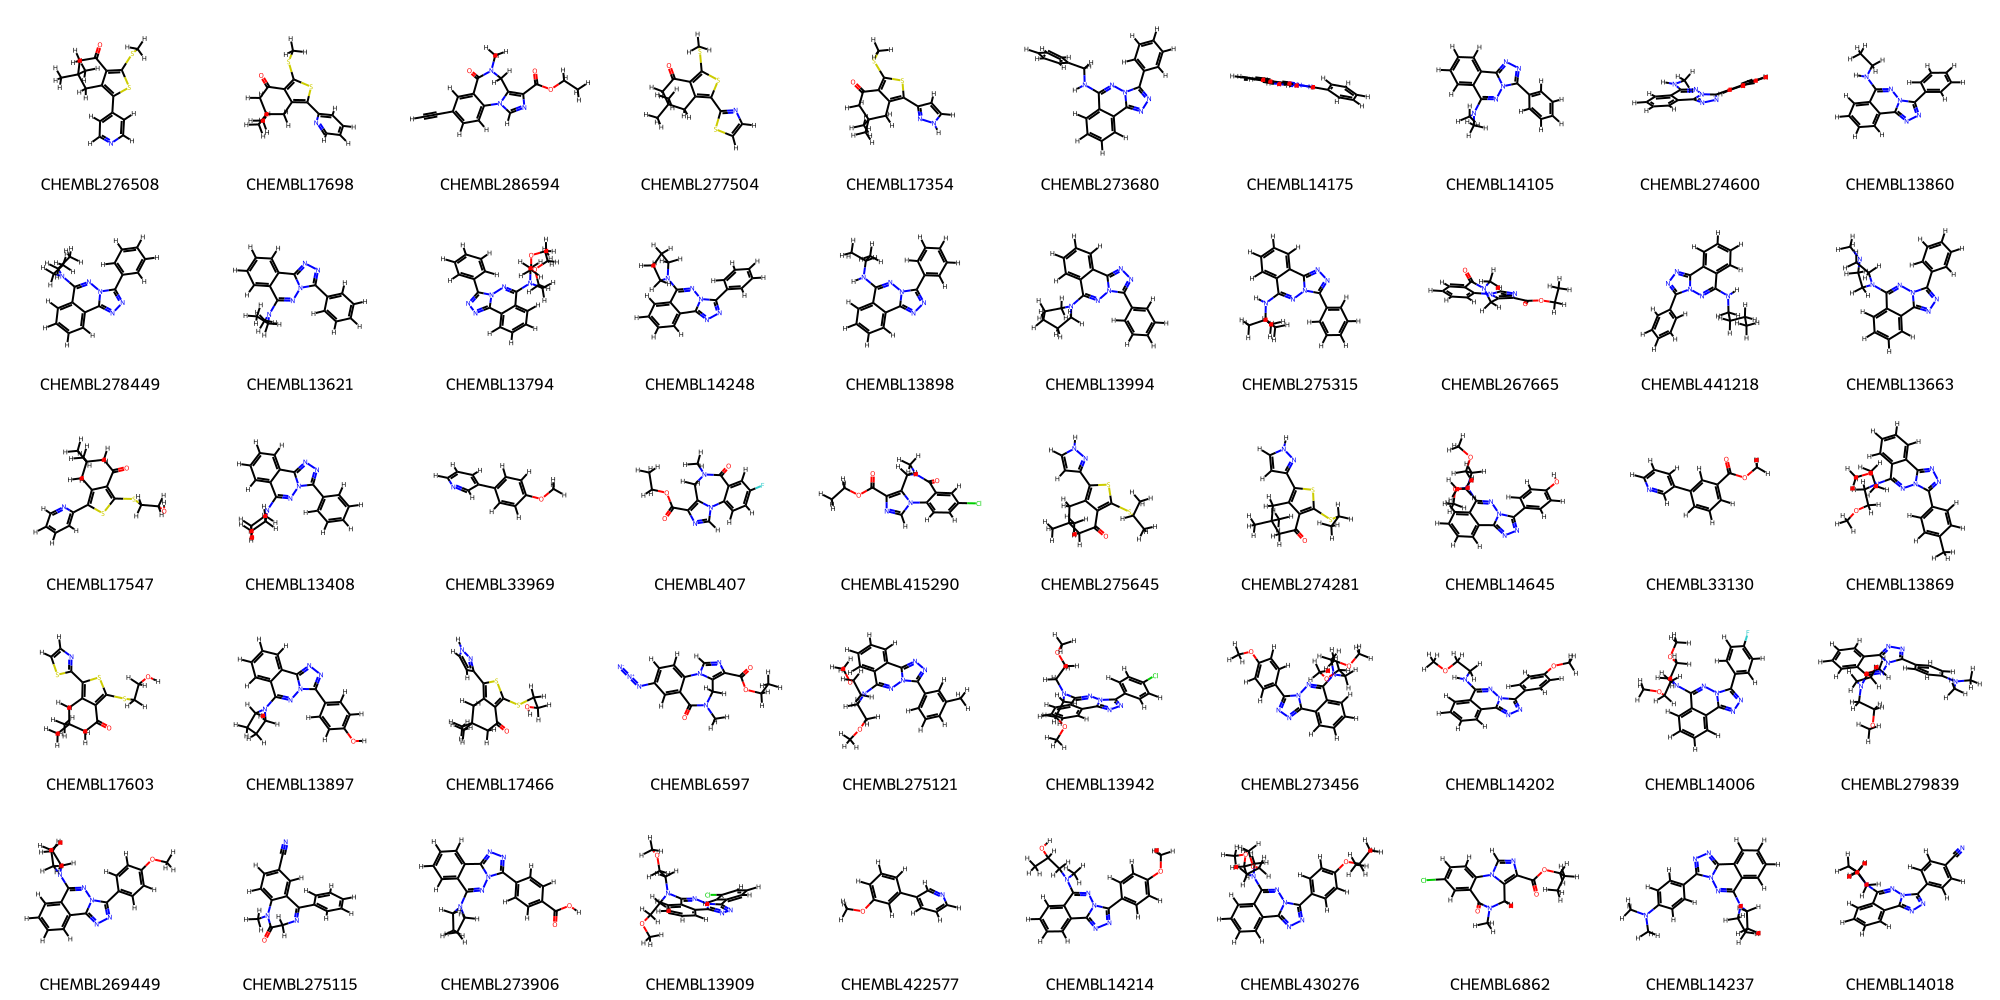

In [ ]:
# Draw a grid with the first 50 molecules
Draw.MolsToGridImage(list(lbvs_mols.values())[:50],molsPerRow=10,legends=list(lbvs_mols.keys())[:50])

In [ ]:
def score_ligand(mol, pharm_features, distthreshold=1.5):
    """
    Score a ligand against the pharmacophore model.

    Args:
        mol: RDKit molecule with 3D coordinates
        pharm_features: DataFrame with consensus pharmacophore
        distthreshold: Distance tolerance (Å)

    Returns:
        score: Number of matching pharmacophore features (0 to max)
    """

    try:
        # FIX #1: Validate 3D coordinates exist
        if mol.GetNumConformers() == 0:
            return 0

        # FIX #2: Use robust conformer selection
        molfeats = factory.GetFeaturesForMol(mol, confId=0)

        # FIX #3: Validate features were extracted
        if not molfeats or len(molfeats) == 0:
            return 0

        score = 0
        for pf in pharm_features:
            pftype = pf['type']
            pfpos = np.array([pf['x'], pf['y'], pf['z']])
            for mf in molfeats:
                if mf.GetFamily() == pftype:
                    dist = np.linalg.norm(mf.GetPos() - pfpos)
                    if dist < distthreshold:
                        score += 1
                        break
        return score
    except:
        return 0

print("  Pharmacophore scoring function defined")

  Pharmacophore scoring function defined


In [ ]:
# Score all LBVS hits
print("Scoring LBVS hits against pharmacophore...\n")


# Conver the dataframe with our pharmacophore features into screening format
DEFAULT_RADIUS = 1.2
pharmit_features = []
for _, row in df_pharmacophore.iterrows():
    pharmit_features.append({
        "type": row["Feature_Family"],
        "x": float(row["X"]),
        "y": float(row["Y"]),
        "z": float(row["Z"]),
        "radius": DEFAULT_RADIUS
    })
DIST_THRESHOLD = 1.5  # distance threshold in Å

# Score all ligands
screening_results = []
for name, mol in lbvs_mols.items():
    smi = Chem.MolToSmiles(mol)
    score = score_ligand(mol, pharmit_features, distthreshold=DIST_THRESHOLD)
    screening_results.append({"Name": name, "SMILES": smi, "Pharmacophore_Score": score})

# Convert to DataFrame and sort by score
df_results = pd.DataFrame(screening_results)
df_results = df_results.sort_values(by="Pharmacophore_Score", ascending=False).reset_index(drop=True)

# Export to Excel
excel_file = "/content/virtual_screening_results.xlsx"
df_results.to_excel(excel_file, index=False)

print(f"\n  Screening completed:")
print(f"  Total LBVS hits screened: {len(df_results)}")
print(f"  Hits with 0 features matched: {len(df_results[df_results['Pharmacophore_Score'] == 0])}")
print(f"  Hits with >0 features matched: {len(df_results[df_results['Pharmacophore_Score'] > 0])}")
print(f"  Results exported to {excel_file}")

Scoring LBVS hits against pharmacophore...


  Screening completed:
  Total LBVS hits screened: 160
  Hits with 0 features matched: 92
  Hits with >0 features matched: 68
  Results exported to /content/virtual_screening_results.xlsx


In [ ]:
 # Display top hits
print("\n" + "="*80)
print("TOP PHARMACOPHORE HITS (Rank by Features Matched)")
print("="*80)
display(df_results.head(20))


TOP PHARMACOPHORE HITS (Rank by Features Matched)


,Name,SMILES,Pharmacophore_Score
0,CHEMBL13794,[H]c1c([H])c([H])c(-c2nnc3c4c([H])c([H])c([H])...,2
1,CHEMBL17547,[H]OC([H])([H])C([H])([H])Sc1sc(-c2nc([H])c([H...,2
2,CHEMBL428687,[H]c1nc([H])c(-c2c(OC([H])([H])[H])c([H])c(C([...,2
3,CHEMBL281992,[H]c1nc([H])c(C(=O)Oc2c([H])c([H])c(-c3c([H])c...,2
4,CHEMBL287742,[H]c1c([H])c([H])c2c(c1[H])-c1c([H])c(C(=O)OC(...,2
5,CHEMBL417498,[H]c1nc([H])c(-c2c([H])c([H])c(OC([H])([H])[H]...,2
6,CHEMBL288670,[H]ON([H])C(=O)c1c([H])nc2c(c(C([H])([H])[H])n...,2
7,CHEMBL418010,[H]c1nc(N([H])c2c([H])c(N([H])C(=O)c3c([H])c([...,2
8,CHEMBL28363,[H]O[C@]1([H])c2c([H])c(OC([H])([H])c3nc([H])c...,2
9,CHEMBL27143,[H]c1nc([H])n(C([H])([H])C([H])([H])Oc2c([H])c...,2


In [ ]:
# Score distribution
print("\nScore distribution:")
score_dist = df_results['Pharmacophore_Score'].value_counts().sort_index(ascending=False)
for score, count in score_dist.items():
    pct = (count/len(df_results))*100
    print(f"  {score:2.0f} features matched: {count:4d} hits ({pct:5.1f}%)")


Score distribution:
   2 features matched:   12 hits (  7.5%)
   1 features matched:   56 hits ( 35.0%)
   0 features matched:   92 hits ( 57.5%)


---

## 7. Filter and Export Pharmacophore-Positive Hits

**Filtering criteria**:
- Keep compounds matching ≥30% of pharmacophore features
- This ensures good 3D fit while allowing some chemical diversity
- Integration with next filter (docking) will further validate

In [ ]:
# Apply pharmacophore filter
min_features_fraction = 0.2
min_features_required = len(df_pharmacophore) * min_features_fraction  # 20% of features or more

df_pharmacophore_hits = df_results[df_results['Pharmacophore_Score'] >= min_features_required].copy()

print(f"Filter Applied: Match ≥{min_features_required:.1f} features ({int(min_features_fraction*100)}% of {len(df_pharmacophore)} total)\n")
print(f"  Pharmacophore-positive hits: {len(df_pharmacophore_hits)} compounds")
print(f"  Filtered out: {len(df_results) - len(df_pharmacophore_hits)} compounds")
print(f"  Hit rate: {(len(df_pharmacophore_hits)/len(df_results))*100:.1f}%")

Filter Applied: Match ≥2.0 features (20% of 10 total)

  Pharmacophore-positive hits: 12 compounds
  Filtered out: 148 compounds
  Hit rate: 7.5%


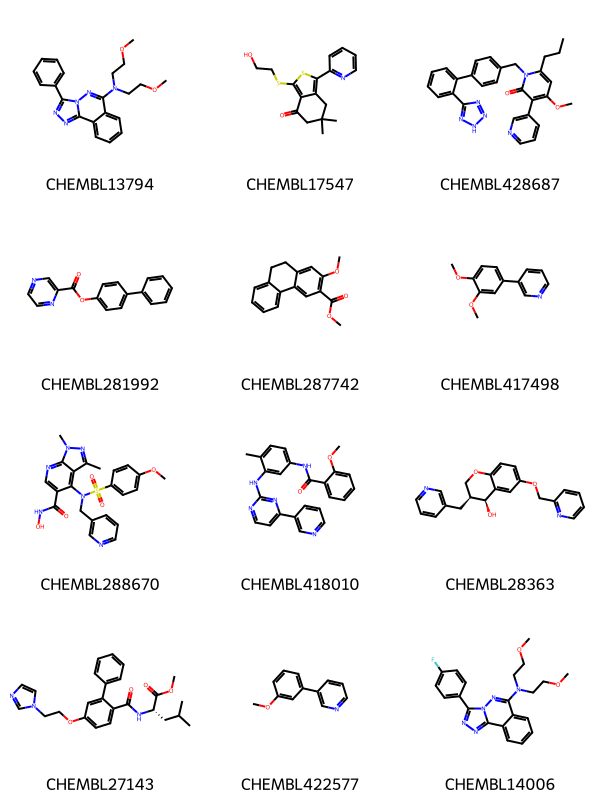

In [ ]:
# Dislpay the hits in a grid
hits_mols = [Chem.MolFromSmiles(smi) for smi in df_pharmacophore_hits['SMILES'].values]
Draw.MolsToGridImage(hits_mols,molsPerRow=3,legends=list(df_pharmacophore_hits['Name'].values))

In [ ]:
# Export results
output_file = 'Pharmacophore_hits_filtered.csv'
df_pharmacophore_hits.to_csv(output_file, index=False)

# Export pharmacophore model
model_file = 'Pharmacophore_Model.csv'
df_pharmacophore.to_csv(model_file, index=False)

print(f" Results exported to: {output_file}")
print(f" Model exported to: {model_file}")

 Results exported to: Pharmacophore_hits_filtered.csv
 Model exported to: Pharmacophore_Model.csv


In [ ]:
# Is our compound with the highest "Similarity_Max" in the screening dataset (lbvs_hits), surviving in the pharmacophore hits?
# Highest similarity: 1.0
# Compounds with highest similarity: CHEMBL17574, CHEMBL276508
print(df_pharmacophore_hits[df_pharmacophore_hits['Name'] == 'CHEMBL276508'])


Empty DataFrame
Columns: [Name, SMILES, Pharmacophore_Score]
Index: []


THe compound with the highest similarity score from Filter 1 does not pass the 3D pharmacophore (Filter 2). The consensus pharmacophore was built only from features shared by the almost half of α2A-selective modulators, so ligands whose key features are rare or idiosyncratic contribute little or nothing to the final model. The training molecule that this hit matches appears to fall into that category: it is highly similar in 2D, but its specific pattern and 3D arrangement of hydrophobic, aromatic and H-bond acceptor features are not well represented in the consensus model, so the corresponding library compound does not reach the minimum number of pharmacophore feature matches and is filtered out.

---

## 8. Summary Report

In [ ]:
# Generate summary report
print("\n" + "="*80)
print("FILTER 2 (PHARMACOPHORE SCREENING) - SUMMARY REPORT")
print("="*80)

print(f"\n1. TRAINING SET ANALYSIS")
print(f"   Training molecules: {len(training_mols)} α2A-selective compounds")
print(f"   Failed conversions: {len(failed_training)}")

print(f"\n2. PHARMACOPHORE GENERATION")
print(f"   Total consensus features: {len(df_pharmacophore)}")
print(f"   Feature types: {df_pharmacophore['Feature_Family'].nunique()}")
print(f"   Distance threshold: {DIST_THRESHOLD} Å")
print(f"   Minimum matches required: {MIN_MATCHES} ligands")

print(f"\n3. LBVS HIT SCREENING")
print(f"   LBVS hits input: {len(df_results)} compounds")
print(f"   Failed conversions: {len(failed_lbvs)}")
print(f"   Average features matched: {df_results['Pharmacophore_Score'].mean():.1f}")
print(f"   Max features matched: {df_results['Pharmacophore_Score'].max()}")
print(f"   Min features matched: {df_results['Pharmacophore_Score'].min()}")

print(f"\n4. PHARMACOPHORE FILTERING (≥{int(min_features_fraction*100)}% features required)")
print(f"   Pharmacophore-positive hits: {len(df_pharmacophore_hits)}")
print(f"   Pass rate: {(len(df_pharmacophore_hits)/len(df_results))*100:.1f}%")
print(f"   Output for Filter 3 (Docking): {len(df_pharmacophore_hits)} compounds")

print(f"\n6. NEXT STEP")
print(f"   Filter 3: Molecular docking to GABA-A α2 and α1 receptor subunits")
print(f"   Scoring: Binding affinity ratio")

print(f"\n" + "="*80)


FILTER 2 (PHARMACOPHORE SCREENING) - SUMMARY REPORT

1. TRAINING SET ANALYSIS
   Training molecules: 22 α2A-selective compounds
   Failed conversions: 0

2. PHARMACOPHORE GENERATION
   Total consensus features: 10
   Feature types: 4
   Distance threshold: 1.5 Å
   Minimum matches required: 10 ligands

3. LBVS HIT SCREENING
   LBVS hits input: 160 compounds
   Failed conversions: 0
   Average features matched: 0.5
   Max features matched: 2
   Min features matched: 0

4. PHARMACOPHORE FILTERING (≥20% features required)
   Pharmacophore-positive hits: 12
   Pass rate: 7.5%
   Output for Filter 3 (Docking): 12 compounds

6. NEXT STEP
   Filter 3: Molecular docking to GABA-A α2 and α1 receptor subunits
   Scoring: Binding affinity ratio

